In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from celeriteflow import CeleriteFlowMatrix

import hemcee

from rotate.k2 import get_light_curve
from rotate.model import RotationModel

/Users/dforeman/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()

In [4]:
epicid = 212509747
# epicid = 212574430
# epicid = 211935509
t, F, yerr = get_light_curve(epicid)
model = RotationModel(t, F, yerr, min_period=1.0)

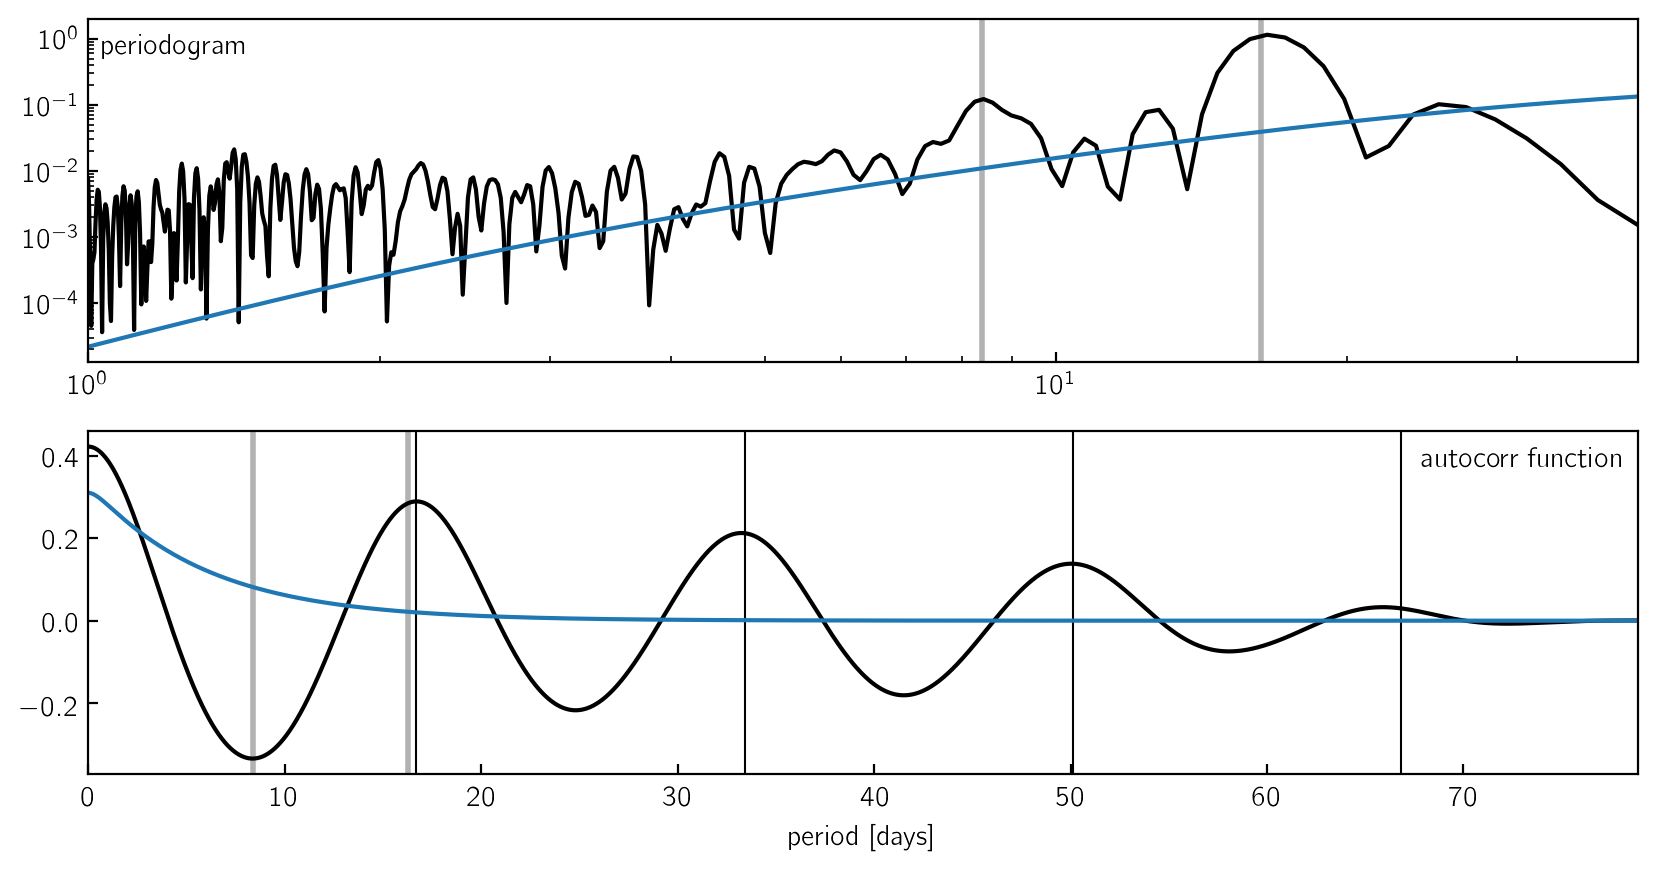

In [5]:
def plot_estimators():  # NOQA
    fig, axes = plt.subplots(2, 1, figsize=(10, 5))

    ax = axes[0]
    freq, power = model.lomb_scargle_result["periodogram"]
    period = 1.0 / freq
    ax.loglog(period, power, "k")
    for peak in model.lomb_scargle_result["peaks"]:
        ax.axvline(peak["period"], color="k", alpha=0.3, lw=2)
    p = len(model.t)**2*model.gp.kernel.get_psd(2*np.pi*freq)/(2*np.pi)
    ax.plot(period, p)
    ax.annotate("periodogram", xy=(0, 1), xycoords="axes fraction",
                ha="left", va="top", xytext=(5, -5),
                textcoords="offset points")
    ax.set_xlim(model.min_period, model.max_period)

    ax = axes[1]
    tau, acor = model.autocorr_result["autocorr"]
    ax.plot(tau, acor, "k")
    for peak in model.lomb_scargle_result["peaks"]:
        ax.axvline(peak["period"], color="k", alpha=0.3, lw=2)
    for peak in model.autocorr_result["peaks"]:
        period = peak["period"]
        t = period
        while t < model.t.max():
            ax.axvline(t, color="k", lw=0.75)
            t += period
    ax.plot(tau, len(model.t)**2*model.gp.kernel.get_value(tau))
    ax.set_xlim(0, model.t.max() - model.t.min())
    ax.annotate("autocorr function", xy=(1, 1), xycoords="axes fraction",
                ha="right", va="top", xytext=(-5, -5),
                textcoords="offset points")

    ax.set_xlabel("period [days]")
    return fig

fig = plot_estimators()

In [6]:
def get_param_for_value(value, min_value, max_value):
    if np.any(value <= min_value) or np.any(value >= max_value):
        raise ValueError("value must be in the range (min_value, max_value)")
    return np.log(value - min_value) - np.log(max_value - value)

def get_value_for_param(param, min_value, max_value):
    return min_value + (max_value - min_value) / (1.0 + np.exp(-param))

def get_bounded_variable(name, value, min_value, max_value, dtype=tf.float64):
    param = tf.Variable(get_param_for_value(value, min_value, max_value), dtype=dtype, name=name + "_param")
    var = min_value + (max_value - min_value) / (1.0 + tf.exp(-param))
    log_jacobian = tf.log(var - min_value) + tf.log(max_value - var) - np.log(max_value - min_value)
    return param, var, tf.reduce_sum(log_jacobian), (min_value, max_value)

In [33]:
T = tf.float64

x = tf.constant(model.t, dtype=T)
y = tf.constant(1e3*(model.fsap-1), dtype=T)[:, None]
yerr2 = tf.constant((1e3*model.yerr**2), dtype=T)

B = tf.constant(model.pld.A, dtype=T)

log_prior = tf.constant(0.0, dtype=T)

def get_sho_real_coefficients(log_S, log_Q, log_w):
    Q = tf.exp(log_Q)
    S = tf.exp(log_S)
    w = tf.exp(log_w)
    f = tf.sqrt(1.0-4.0*Q**2)
    return (
        0.5*S*w*Q*tf.stack([1.0+1.0/f, 1.0-1.0/f]),
        0.5*w/Q*tf.stack([1.0-f, 1.0+f])
    )

def get_sho_complex_coefficients(log_S, log_Q, log_w):
    Q = tf.exp(log_Q)
    S = tf.exp(log_S)
    w = tf.exp(log_w)
    f = tf.sqrt(4.0*Q**2-1.0)
    return (
        S * w * Q,
        S * w * Q / f,
        0.5 * w / Q,
        0.5 * w / Q * f,
    )

# The simple kernel
y_var = np.var(1e3*(model.fsap-1))
log_S0 = tf.Variable(np.log(y_var), dtype=T, name="log_S0")
log_w0_param, log_w0, log_jac, log_w0_range = get_bounded_variable(
    "log_w0", np.log(2*np.pi/10), np.log(2*np.pi/80), np.log(2*np.pi/1), dtype=T)
log_prior += log_jac
log_jitter2_param, log_jitter2, log_jac, log_jitter2_range = get_bounded_variable(
    "log_jitter2", -5.0, -20.0, 5.0, dtype=T)
log_prior += log_jac
a_real, c_real = get_sho_real_coefficients(log_S0, -np.log(4.0), log_w0)
simple_params = [log_S0, log_w0_param, log_jitter2_param] 

# The rotation kernel
log_a = tf.Variable(np.log(y_var), dtype=T, name="log_a")
log_Q1_param, log_Q1, log_jac, log_Q1_range = get_bounded_variable(
    "log_Q1", np.log(7.0), -5.0, 5.0, dtype=T)
log_prior += log_jac
mix_param, mix, log_jac, mix_range = get_bounded_variable(
    "mix", 0.4, 0.0, 1.0, dtype=T)
log_prior += log_jac
log_Q2_param, log_Q2, log_jac, log_Q2_range = get_bounded_variable(
    "log_Q2", np.log(7.0), -0.5*np.log(2.0), 5.0, dtype=T)
log_prior += log_jac
log_P_param, log_P, log_jac, log_P_range = get_bounded_variable(
    "log_P", np.log(model.period), 0.0, np.log(40.0), dtype=T)
log_prior += log_jac

rotation_params = [log_a, log_Q1_param, mix_param, log_Q2_param, log_P_param]

# Compute the parameters of the 2 SHO models
Q = tf.exp(log_Q2) + tf.exp(log_Q1)
log_Q1 = tf.log(Q)
P = tf.exp(log_P)
log_omega1 = tf.log(4*np.pi*Q) - tf.log(P) - 0.5*tf.log(4.0*Q*Q-1.0)
log_S1 = log_a - log_omega1 - log_Q1

Q = tf.exp(log_Q2)
P = 0.5*tf.exp(log_P)
log_omega2 = tf.log(4*np.pi*Q) - tf.log(P) - 0.5*tf.log(4.0*Q*Q-1.0)
log_S2 = mix + log_a - log_omega2 - log_Q2

a1, b1, c1, d1 = get_sho_complex_coefficients(log_S1, log_Q1, log_omega1)
a2, b2, c2, d2 = get_sho_complex_coefficients(log_S2, log_Q2, log_omega2)
a_comp = tf.stack([a1, a2])
b_comp = tf.stack([b1, b2])
c_comp = tf.stack([c1, c2])
d_comp = tf.stack([d1, d2])

# Other parameters
mean = tf.Variable(np.mean(1e3*(model.fsap-1)), dtype=T)
log_lambda = tf.Variable(np.zeros(model.pld.nblocks), dtype=T)
log_lam_param, log_lambda, log_jac, log_lam_range = get_bounded_variable(
    "log_lambda", np.zeros(model.pld.nblocks), -5.0, 0.1, dtype=T)
log_prior += log_jac

other_params = [log_lam_param]

# Compute the celerite model
celerite = CeleriteFlowMatrix(a_real, c_real, a_comp, b_comp, c_comp, d_comp, x, tf.exp(log_jitter2) + yerr2 + tf.zeros_like(x))
r = y - mean
alpha = celerite.apply_inverse(r)

log_like_dt = -0.5 * tf.squeeze(tf.matmul(r, alpha, transpose_a=True))
log_like_dt -= 0.5 * celerite.log_determinant
log_prob_dt = log_prior + log_like_dt
var_list_dt = simple_params + rotation_params

value = tf.squeeze(tf.matmul(r, alpha, transpose_a=True))
BTalpha = tf.matmul(B, alpha, transpose_a=True)
KB = celerite.apply_inverse(B)
BTKinvB = tf.matmul(B, KB, transpose_a=True)

inds = np.concatenate([i + np.zeros(s, dtype=int) for i, s in enumerate(model.pld.block_sizes)])
diag = tf.gather(tf.exp(-log_lambda), inds)
S = BTKinvB + tf.diag(diag)
factor = tf.linalg.cholesky(S)
SinvBTalpha = tf.cholesky_solve(factor, BTalpha)
value -= tf.squeeze(tf.matmul(BTalpha, SinvBTalpha, transpose_a=True))

log_det = celerite.log_determinant
log_det += tf.reduce_sum(log_lambda * model.pld.nblocks)
log_det += 2*tf.reduce_sum(tf.log(tf.diag_part(factor)))

log_like = -0.5 * (value + log_det)

# Compute the prior

# And the log prob
log_prob = log_prior + log_like
var_list = simple_params + rotation_params + other_params

# Predictions

# PLD model:
weights = BTalpha - tf.matmul(BTKinvB, SinvBTalpha)
weights /= diag[:, None]
pld_model = tf.squeeze(tf.matmul(B, weights))

# GP model:
nada = tf.constant([], dtype=T)
noise_free = CeleriteFlowMatrix(a_real, c_real, a_comp, b_comp, c_comp, d_comp, x, tf.zeros_like(x))
gp_model = tf.squeeze(noise_free.matmul(celerite.apply_inverse(y - mean - pld_model[:, None])))

session.run(tf.global_variables_initializer())

In [34]:
session.run(pld_model).shape

(3045,)

In [35]:
session.run(gp_model).shape

(3045,)

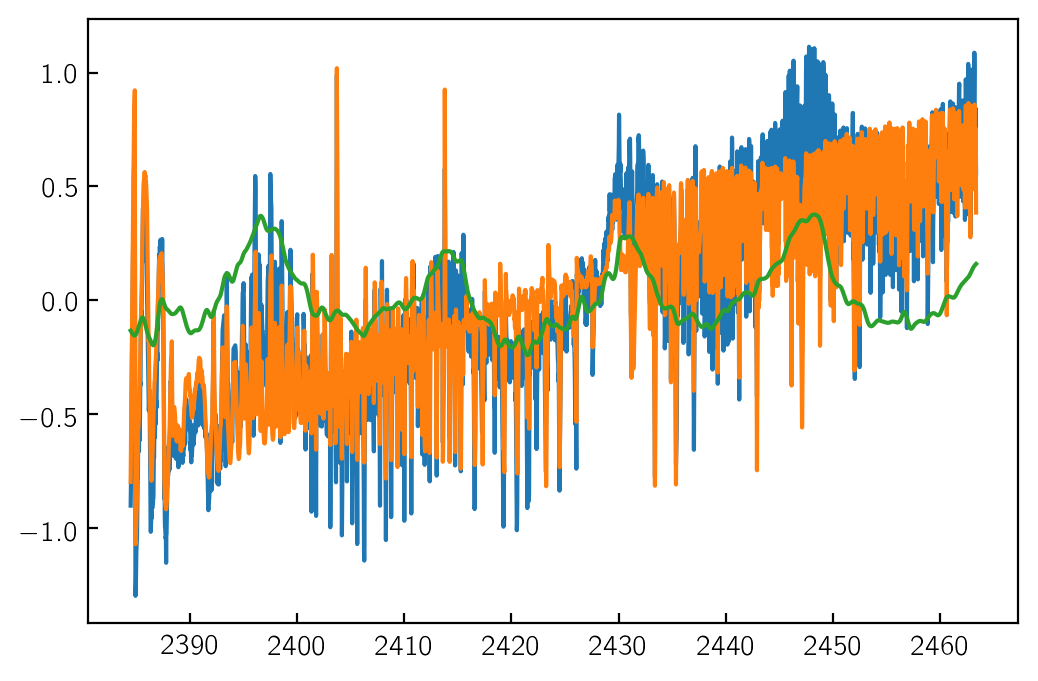

In [36]:
plt.plot(model.t, session.run(y))
plt.plot(model.t, session.run(mean + pld_model))
plt.plot(model.t, session.run(mean + gp_model))

In [37]:
session.run(log_jitter2)

-5.000000000000002

In [42]:
neg_log_prob = -log_prob
opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=var_list)
opt.minimize(session)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -5423.860555
  Number of iterations: 1
  Number of functions evaluations: 3


In [43]:
session.run(log_prob)

5423.860555272107

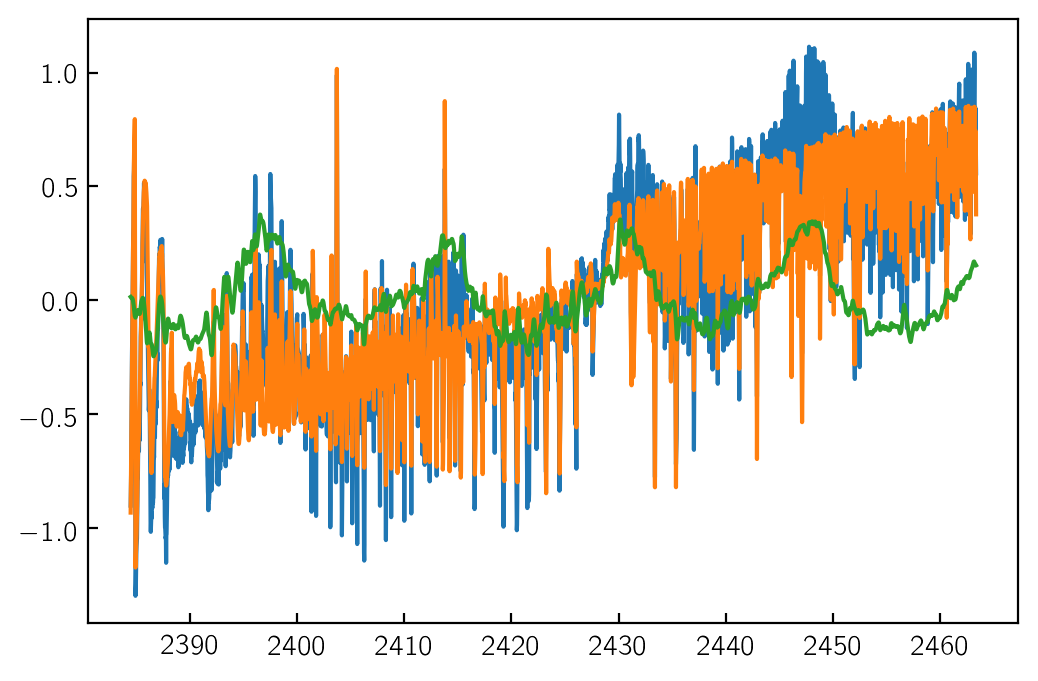

In [44]:
plt.plot(model.t, session.run(y))
plt.plot(model.t, session.run(mean + pld_model))
plt.plot(model.t, session.run(mean + gp_model))

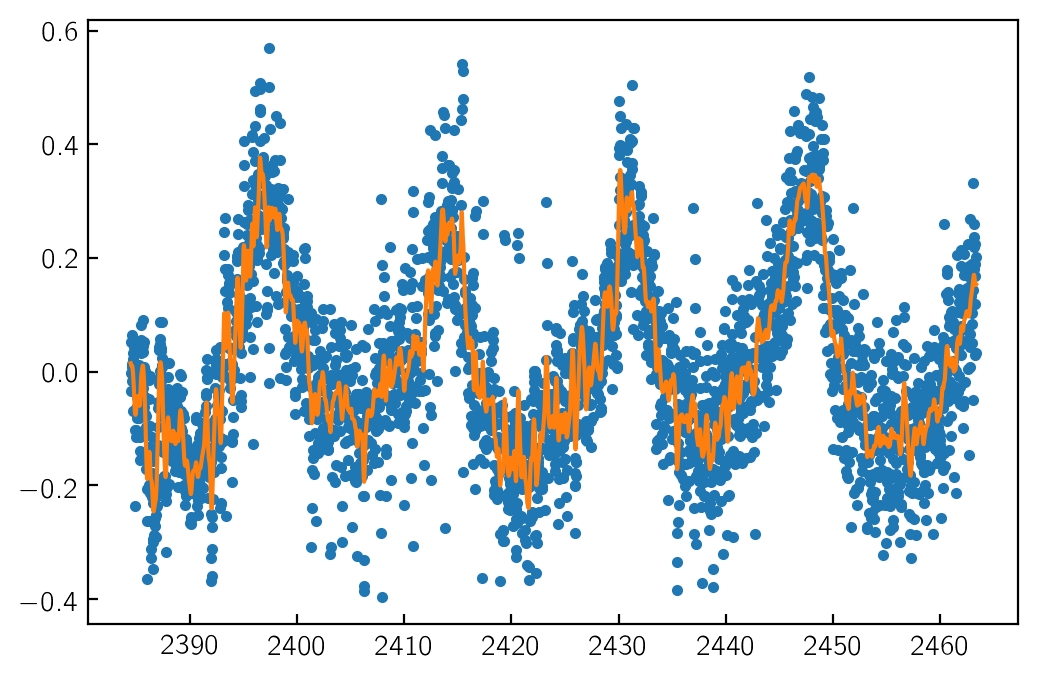

In [45]:
plt.plot(model.t, session.run(y[:, 0] - pld_model), ".")
plt.plot(model.t, session.run(mean + gp_model))

In [46]:
from helpers import TFModel
tf_model = TFModel(log_prob_dt, var_list_dt, feed_dict={y: session.run(y-pld_model[:, None])})
tf_model.setup(session)

In [47]:
tf_model.current_vector()

array([-5.1430087 ,  5.34125596,  0.41467512, -5.55473348,  0.0760321 ,
        0.02395968,  1.1995361 ,  2.98603395])

In [48]:
import hemcee

metric = hemcee.metric.DenseMetric(np.eye(len(tf_model.current_vector())))
sampler = hemcee.NoUTurnSampler(tf_model.value, tf_model.gradient, metric=metric)

In [49]:
q, lp = sampler.run_warmup(tf_model.current_vector(), 2000)

initial warm up: step_size: 2.0e-03; mean(accept_stat): 0.468: 100%|██████████| 100/100 [00:26<00:00,  2.27it/s]
warm up 1/7: step_size: 1.9e-02; mean(accept_stat): 0.512: 100%|██████████| 25/25 [00:07<00:00,  3.42it/s]
warm up 2/7: step_size: 2.0e-01; mean(accept_stat): 0.490: 100%|██████████| 25/25 [00:06<00:00,  3.27it/s]
warm up 3/7: step_size: 1.0e+00; mean(accept_stat): 0.487: 100%|██████████| 50/50 [00:12<00:00,  3.94it/s]
warm up 4/7: step_size: 7.5e-01; mean(accept_stat): 0.501: 100%|██████████| 100/100 [00:21<00:00,  6.51it/s]
warm up 5/7: step_size: 1.4e+00; mean(accept_stat): 0.497: 100%|██████████| 200/200 [00:26<00:00,  8.98it/s]
warm up 6/7: step_size: 4.7e-01; mean(accept_stat): 0.496: 100%|██████████| 400/400 [00:40<00:00,  9.98it/s]
warm up 7/7: step_size: 5.9e-01; mean(accept_stat): 0.499: 100%|██████████| 1000/1000 [01:40<00:00, 13.84it/s]
final warm up: step_size: 6.7e-01; mean(accept_stat): 0.495: 100%|██████████| 100/100 [00:11<00:00,  8.59it/s]


In [50]:
q, lp = sampler.run_mcmc(q, 2000)

step_size: 7.4e-01; mean(accept_stat): 0.506: 100%|██████████| 2000/2000 [04:08<00:00,  8.03it/s]


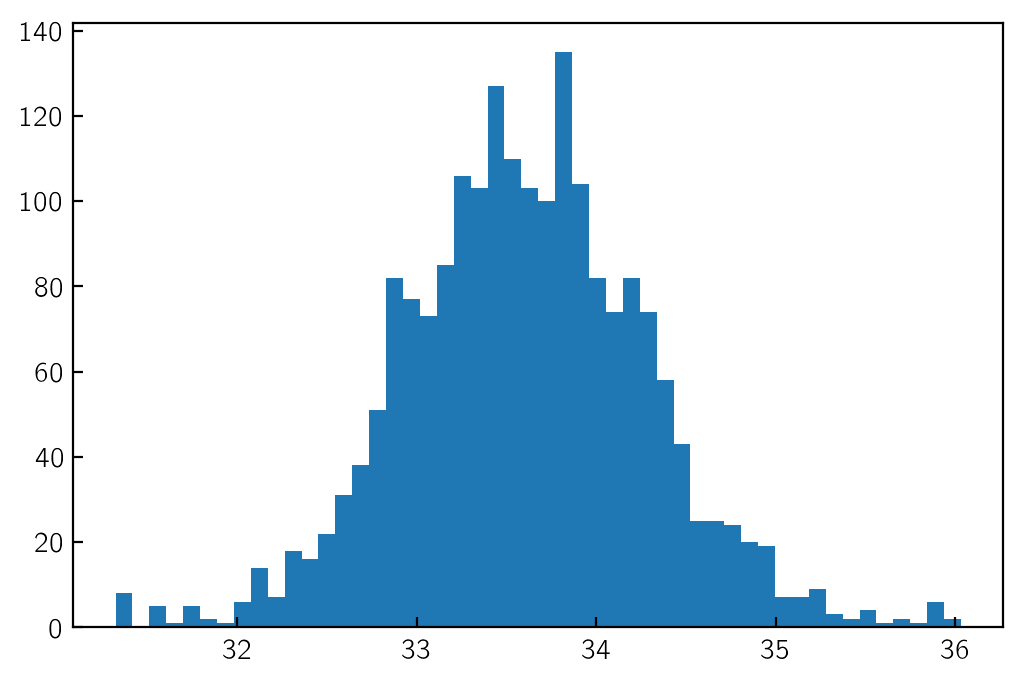

In [51]:
plt.hist(np.exp(get_value_for_param(q[:, -1], *log_P_range)), 50);

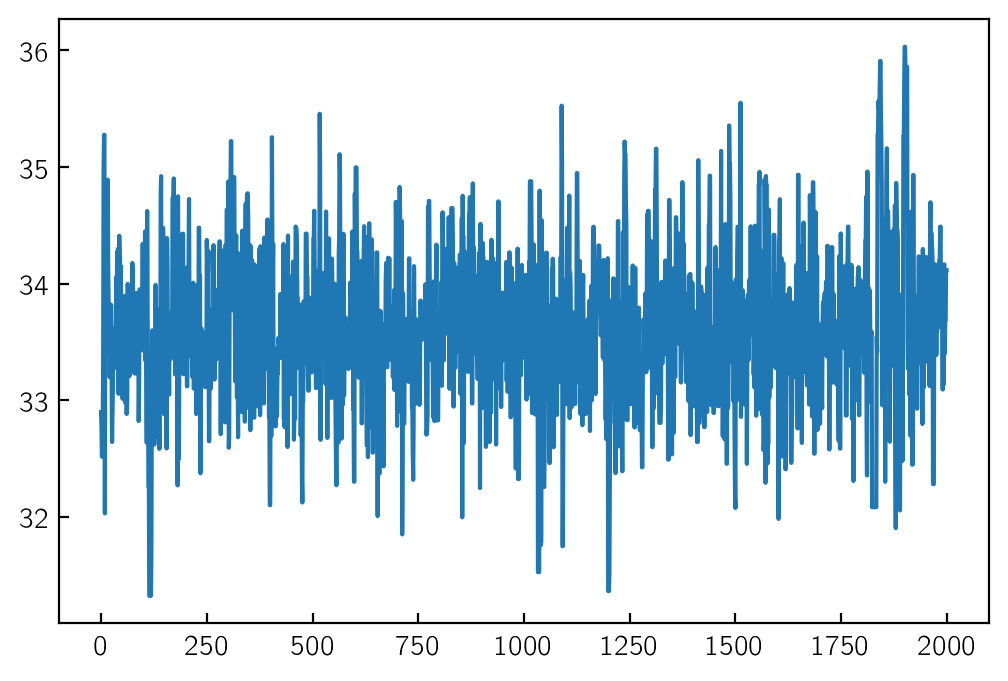

In [52]:
plt.plot(np.exp(get_value_for_param(q[:, -1], *log_P_range)));

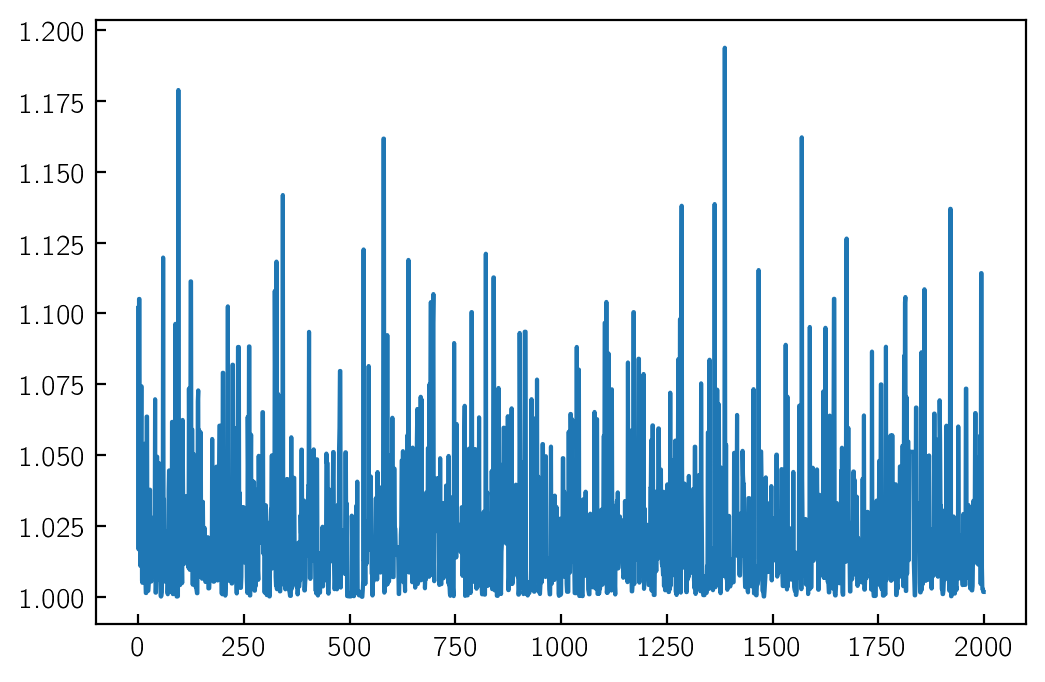

In [53]:
plt.plot(2*np.pi*np.exp(-get_value_for_param(q[:, 1], *log_w0_range)));

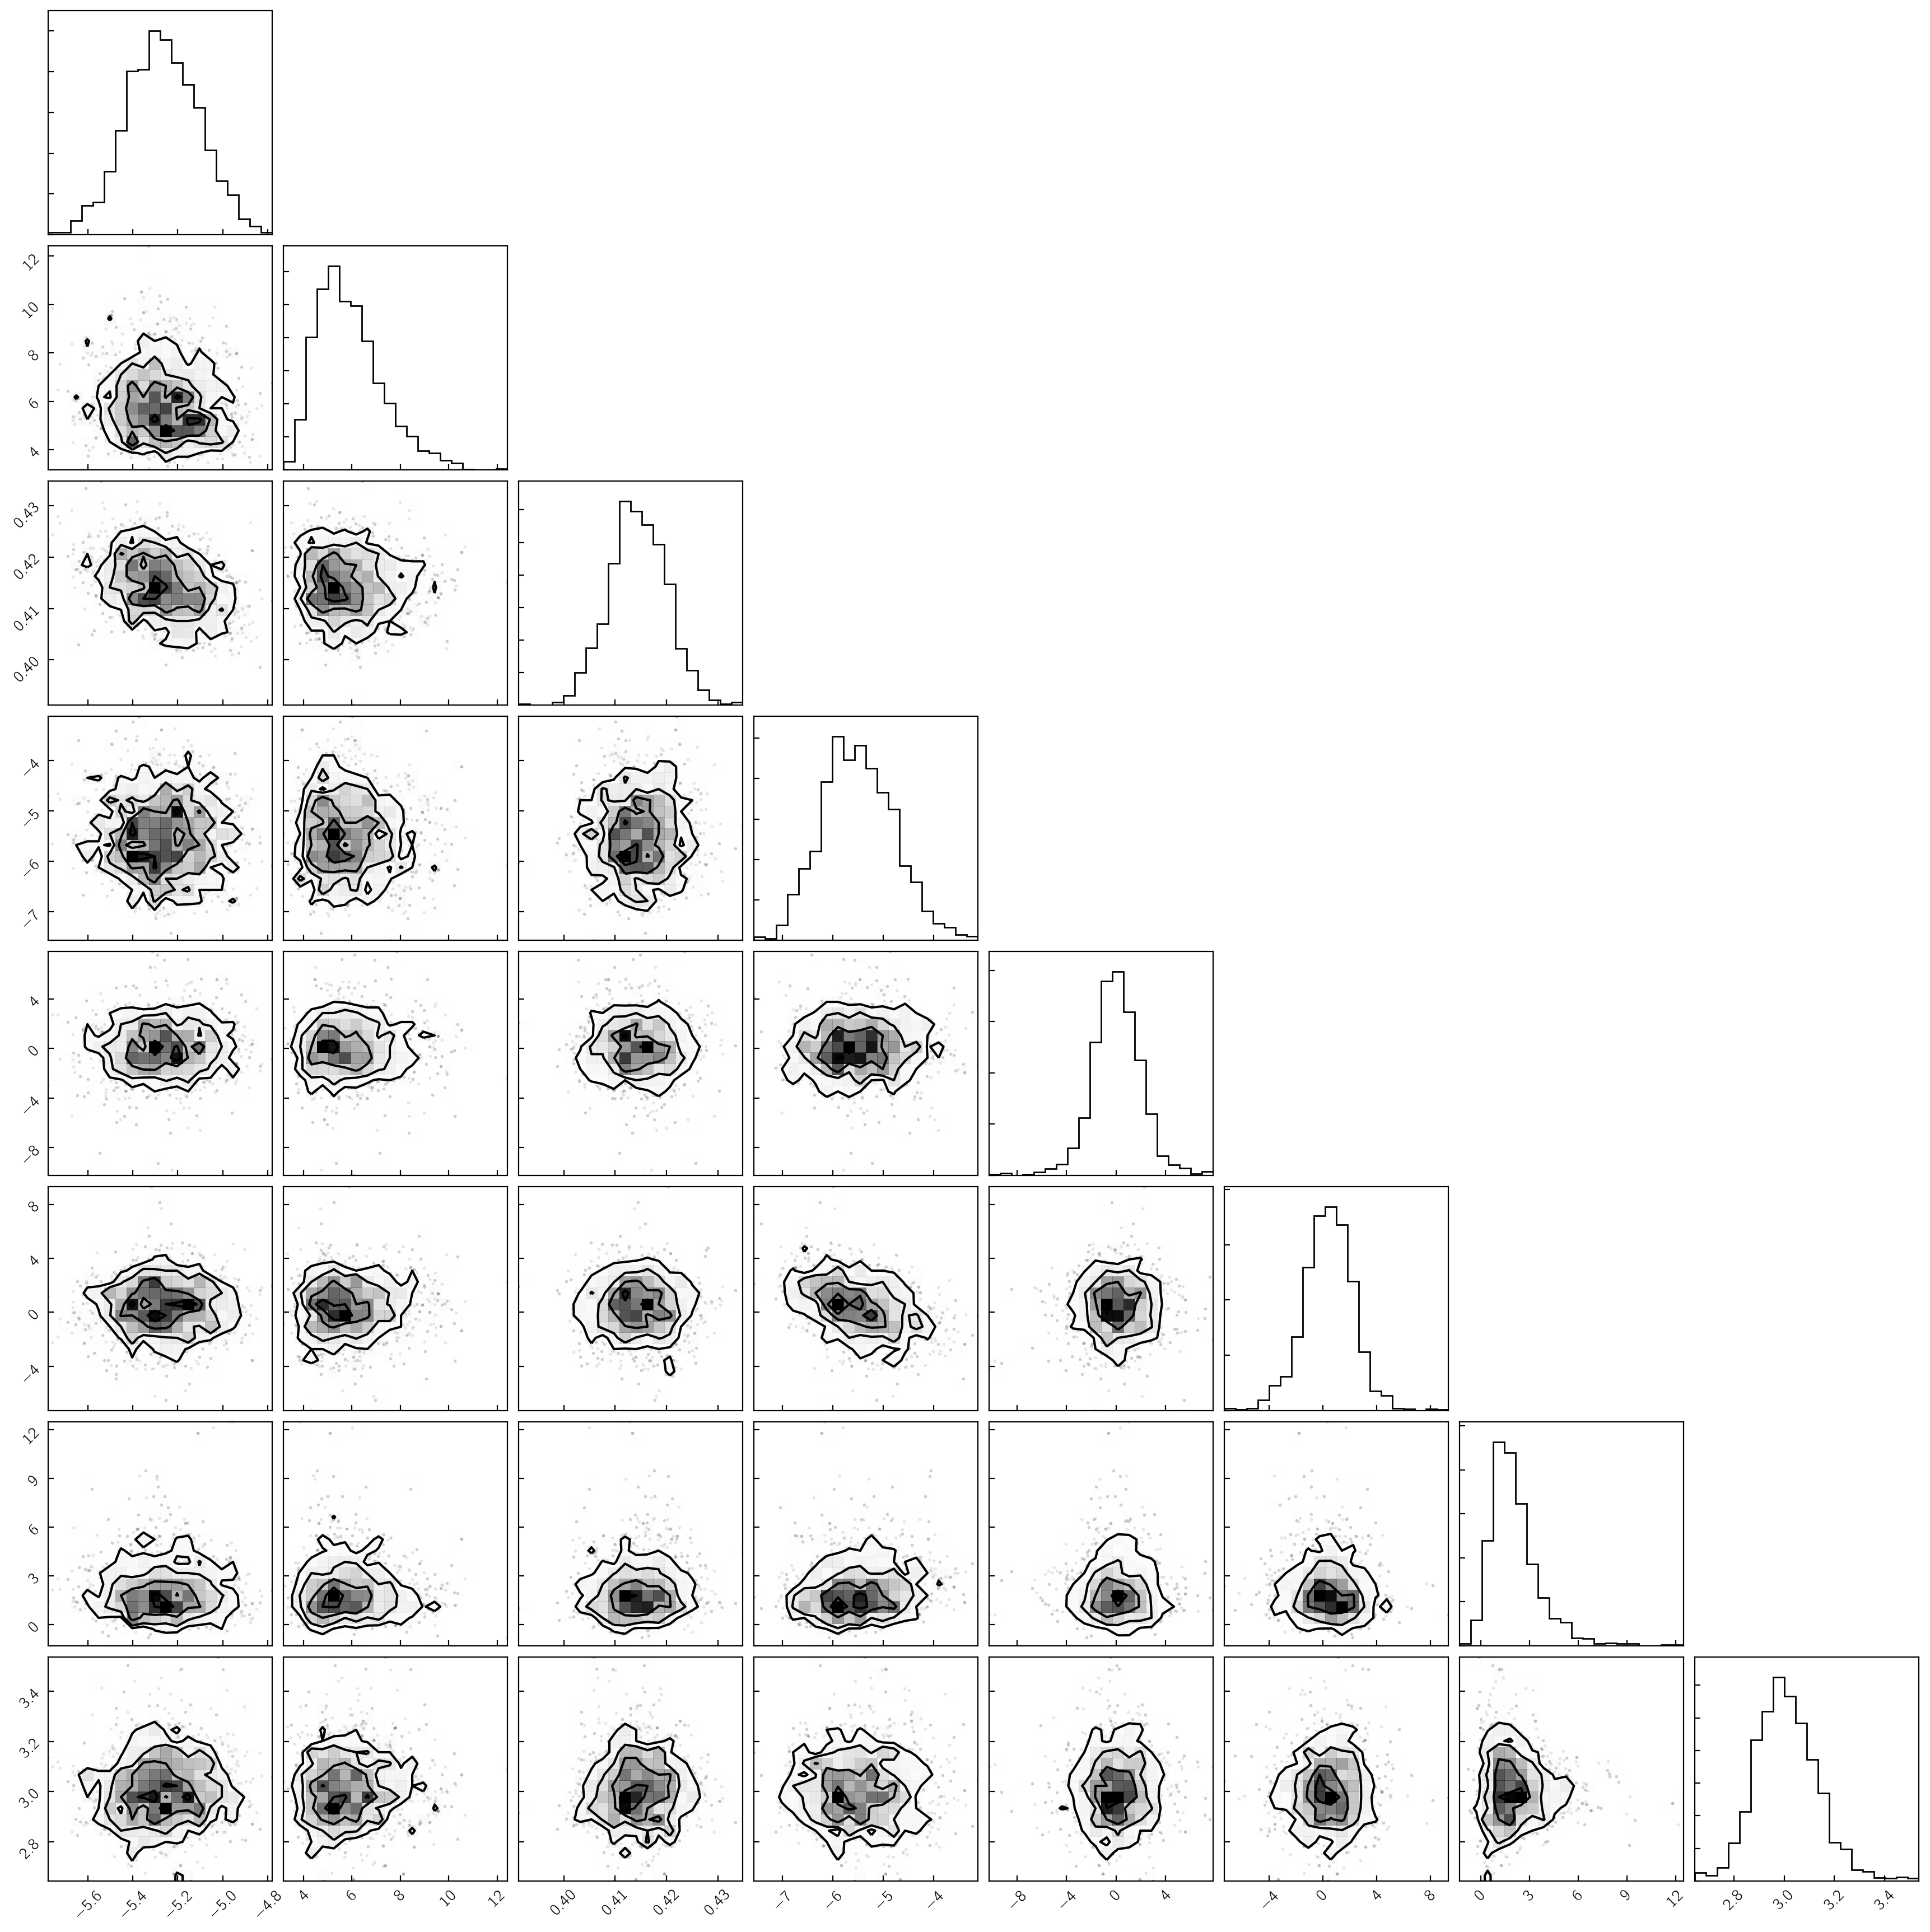

In [54]:
import corner
corner.corner(q);

In [57]:
nada = tf.constant([], dtype=T)
new_noise_free = CeleriteFlowMatrix(nada, nada, a_comp, b_comp, c_comp, d_comp, x, tf.zeros_like(x))
new_gp_model = tf.squeeze(new_noise_free.matmul(celerite.apply_inverse(y - mean)))

In [63]:
per = np.linspace(50.0, 1.0, 100000)
omega = 2 * np.pi / per
num = (a_comp * c_comp + b_comp * d_comp) * (tf.square(c_comp) + tf.square(d_comp)) + (a_comp * c_comp - b_comp * d_comp) * tf.square(omega)[:, None]
denom = (omega**4)[:, None] + 2*(tf.square(c_comp) - tf.square(d_comp)) * tf.square(omega)[:, None] + tf.square(tf.square(c_comp) + tf.square(d_comp)) 
psds = np.sqrt(2.0 / np.pi) * num / denom
psd = tf.reduce_sum(psds, 1)

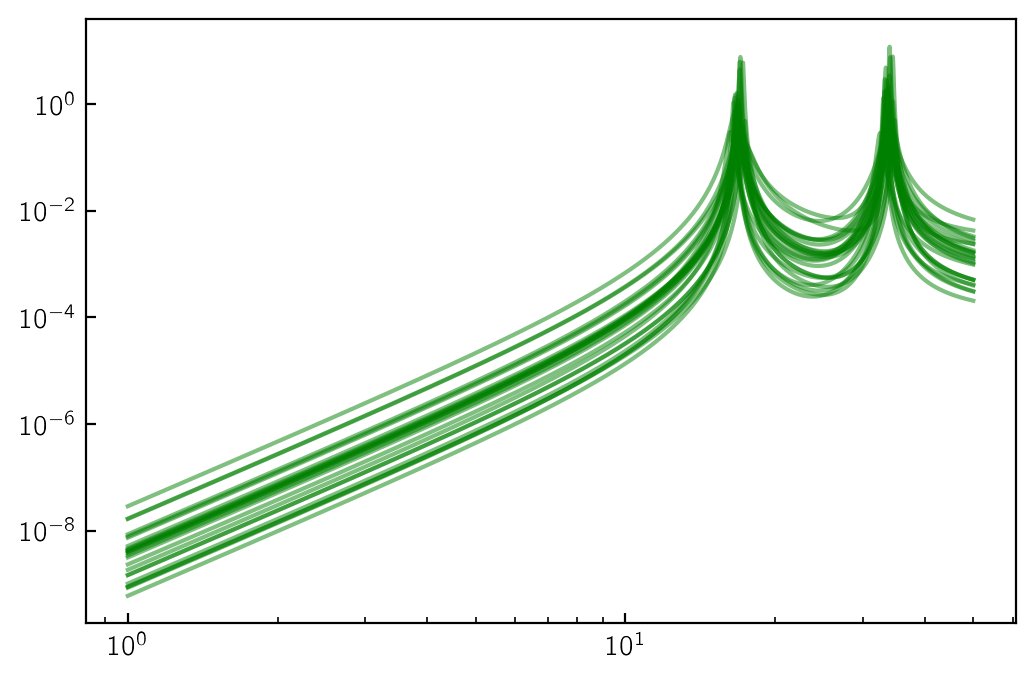

In [65]:
for i in np.random.randint(len(q), size=25):
    fd = tf_model.vector_to_feed_dict(q[i])
    plt.loglog(per, session.run(psd, feed_dict=fd), "g", alpha=0.5)

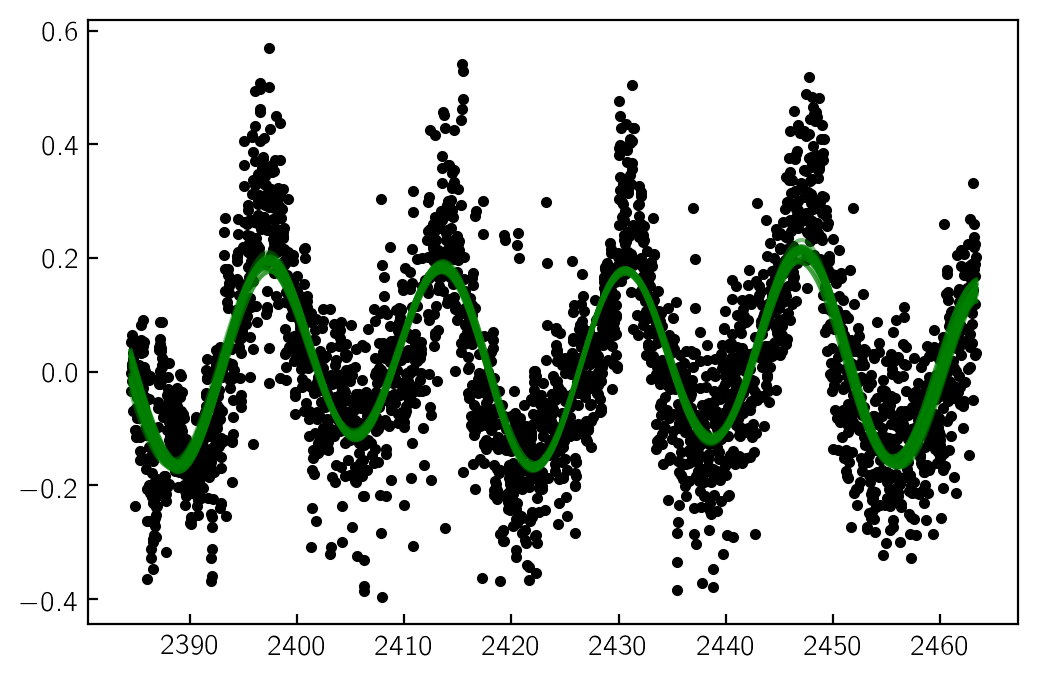

In [60]:
plt.plot(model.t, session.run(y[:, 0] - pld_model), "k.")

for i in np.random.randint(len(q), size=25):
    fd = tf_model.vector_to_feed_dict(q[i])
    plt.plot(model.t, session.run(mean + new_gp_model, feed_dict=fd), "g", alpha=0.5)

In [59]:
var_list_dt

[<tf.Variable 'log_S0_2:0' shape=() dtype=float64_ref>,
 <tf.Variable 'log_w0_param_2:0' shape=() dtype=float64_ref>,
 <tf.Variable 'log_jitter2_param_2:0' shape=() dtype=float64_ref>,
 <tf.Variable 'log_a_2:0' shape=() dtype=float64_ref>,
 <tf.Variable 'log_Q1_param_2:0' shape=() dtype=float64_ref>,
 <tf.Variable 'mix_param_2:0' shape=() dtype=float64_ref>,
 <tf.Variable 'log_Q2_param_2:0' shape=() dtype=float64_ref>,
 <tf.Variable 'log_P_param_2:0' shape=() dtype=float64_ref>]